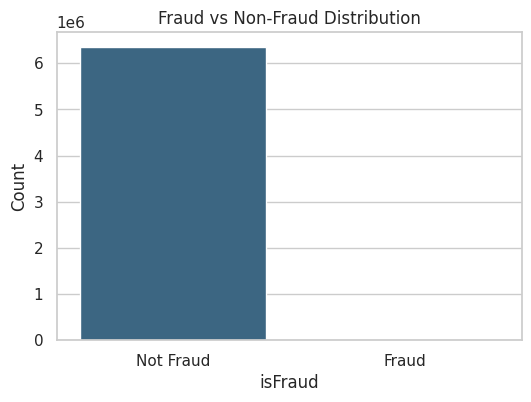

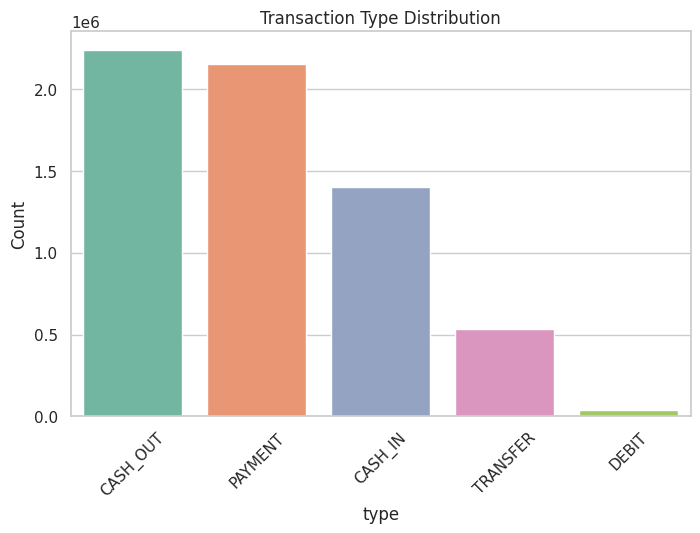

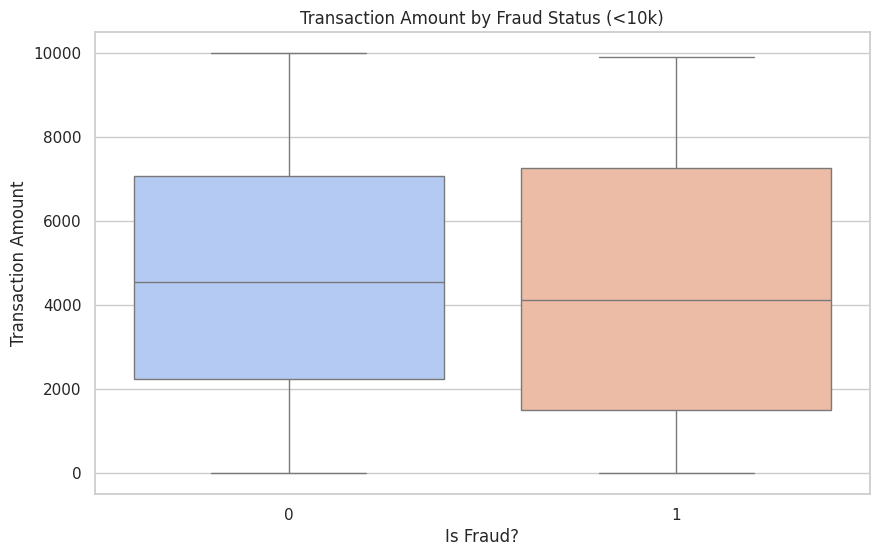

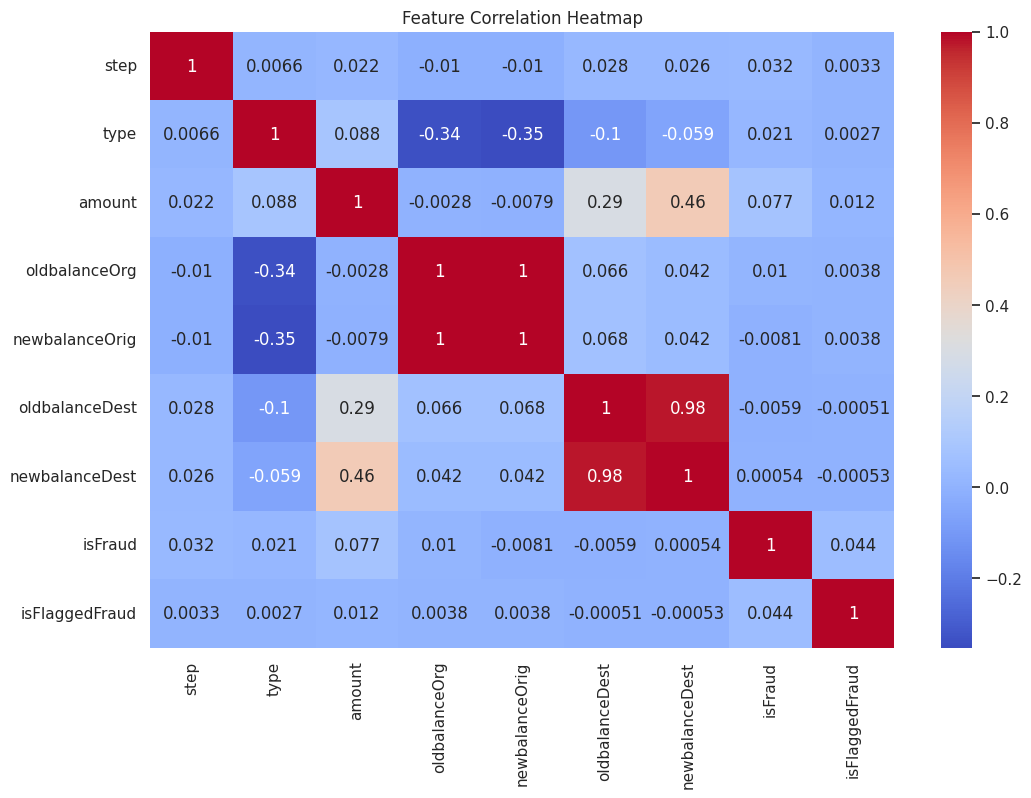

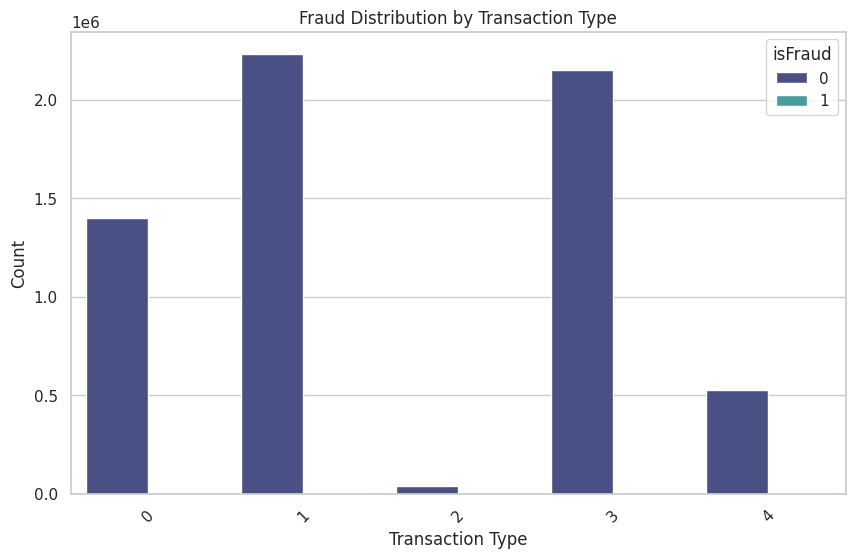

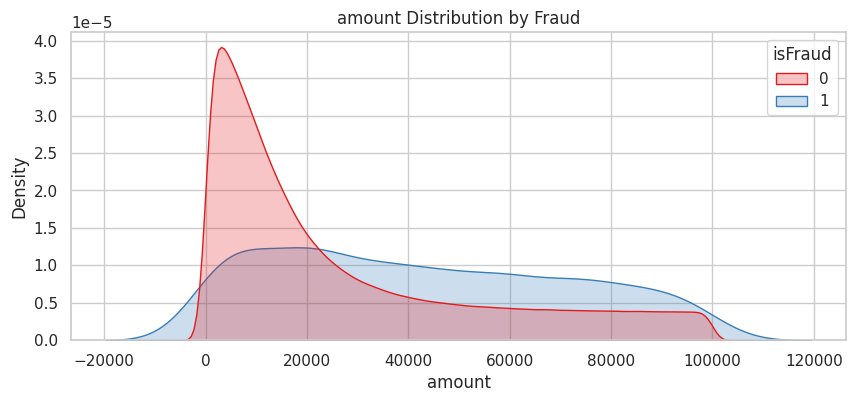

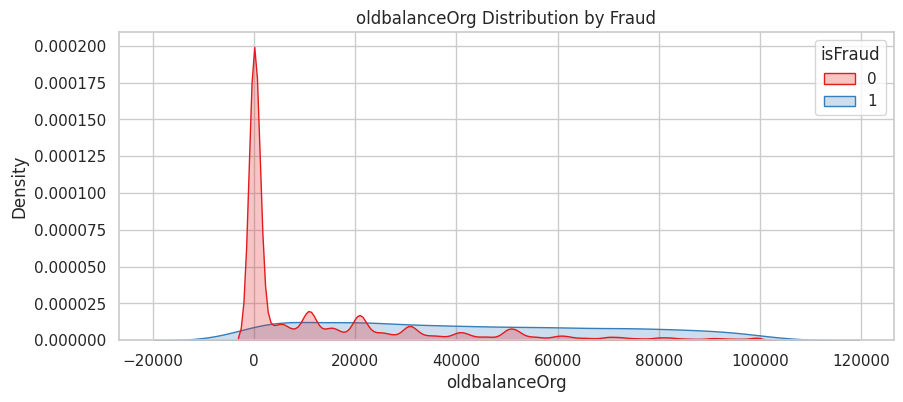

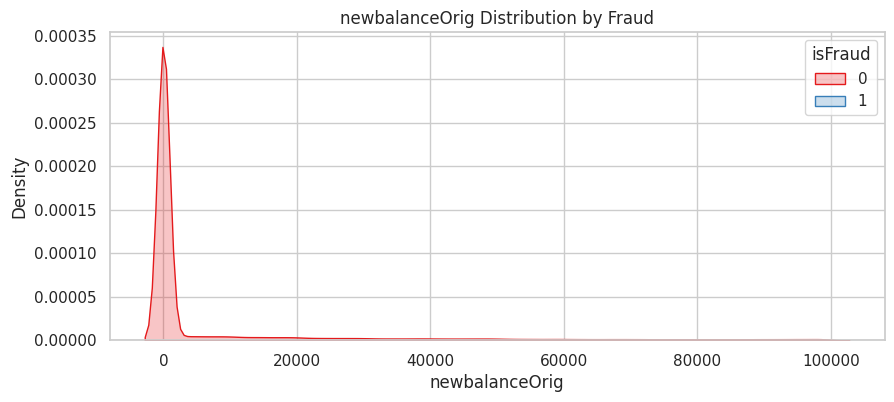

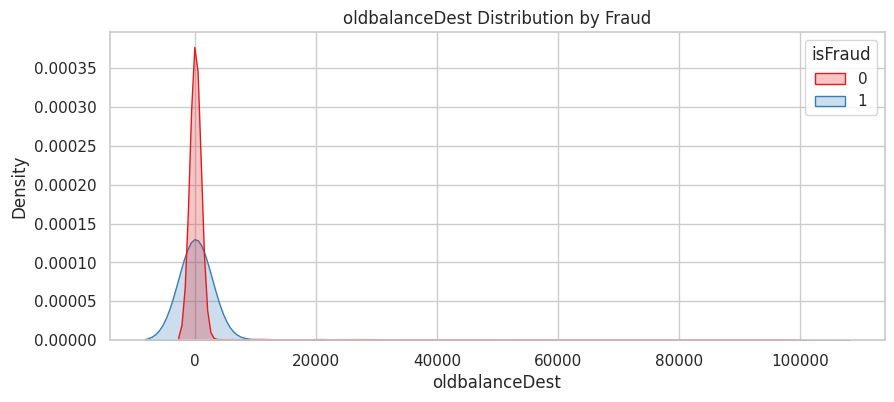

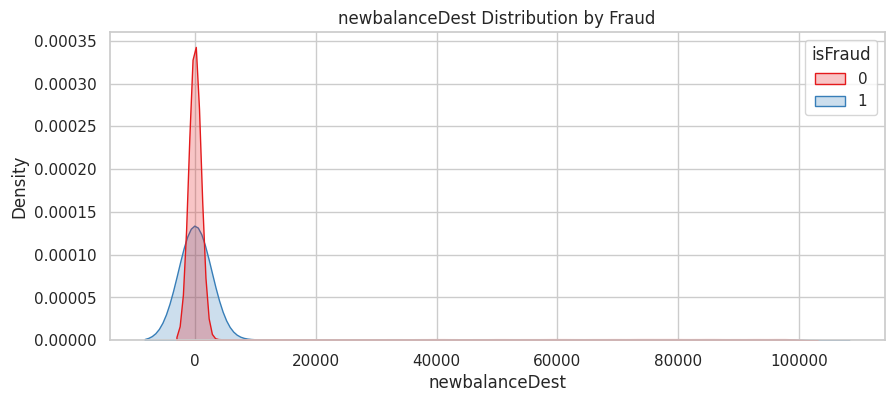


Training: Logistic Regression


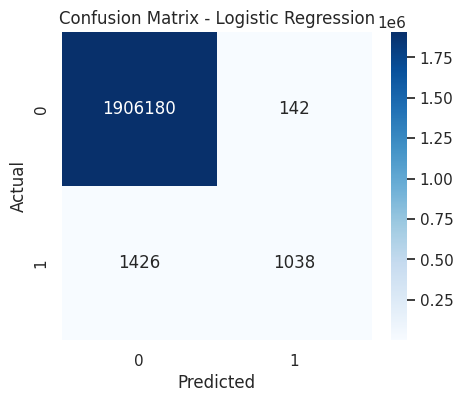


Training: Decision Tree


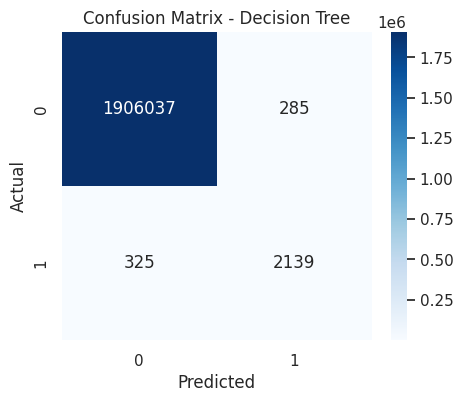


Training: KNN


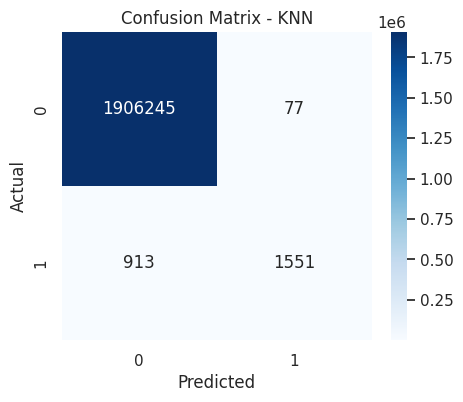


Training: XGBoost


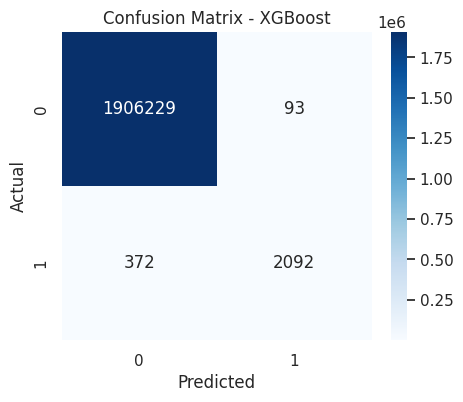

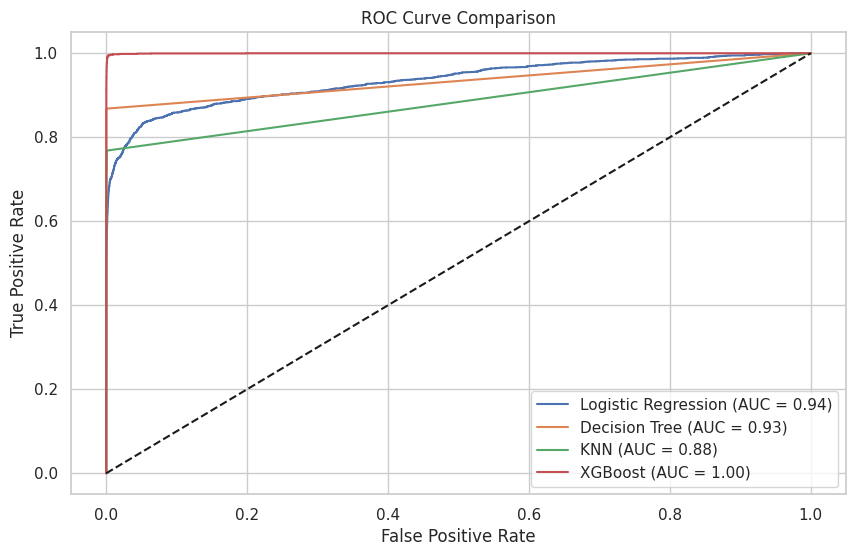

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
3              XGBoost  0.999756   0.957437  0.849026  0.899978  0.999766
1        Decision Tree  0.999680   0.882426  0.868101  0.875205  0.933976
2                  KNN  0.999481   0.952703  0.629464  0.758065  0.883963
0  Logistic Regression  0.999179   0.879661  0.421266  0.569704  0.935225


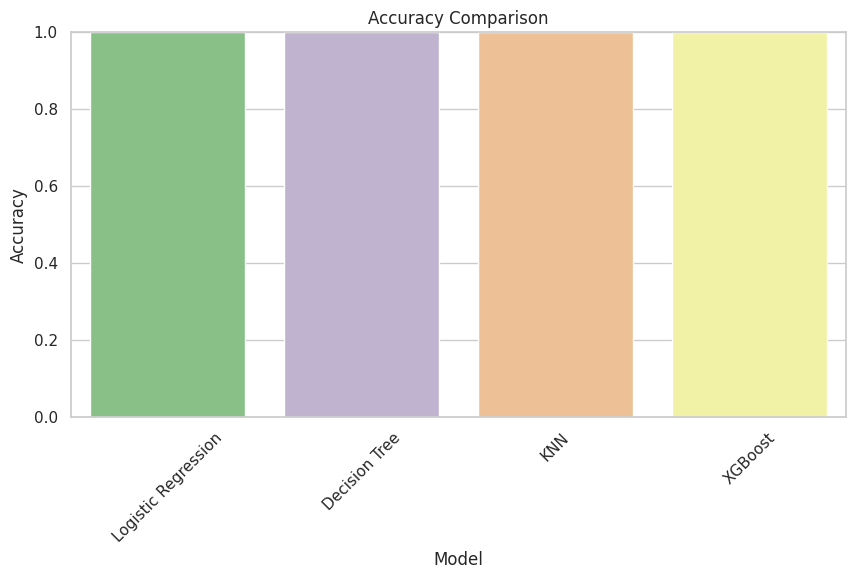

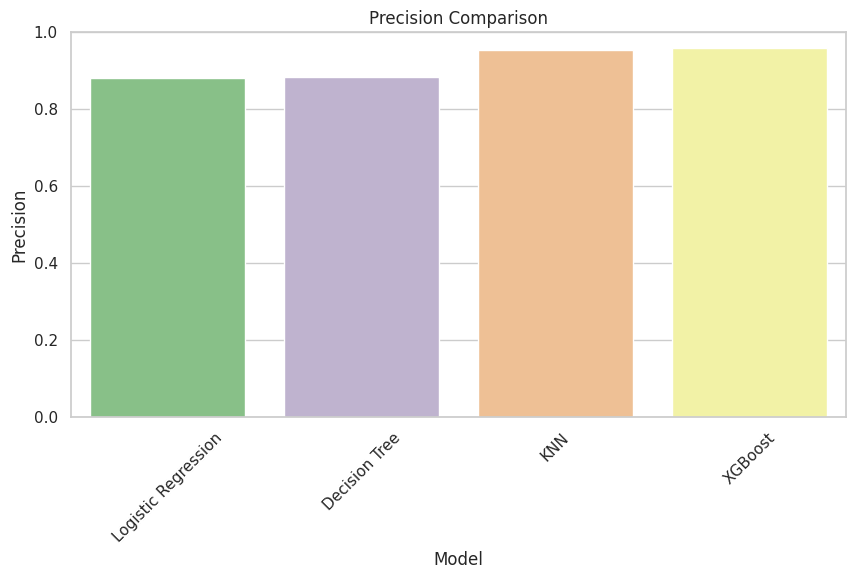

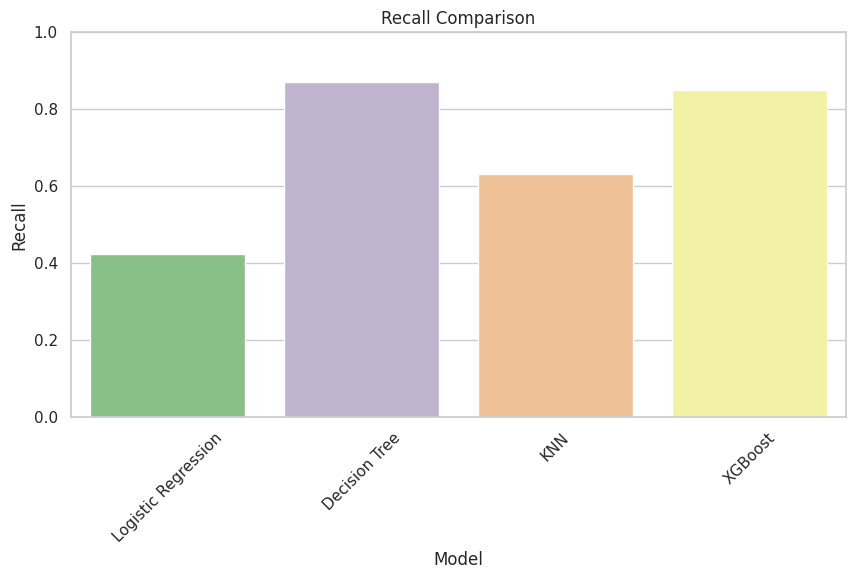

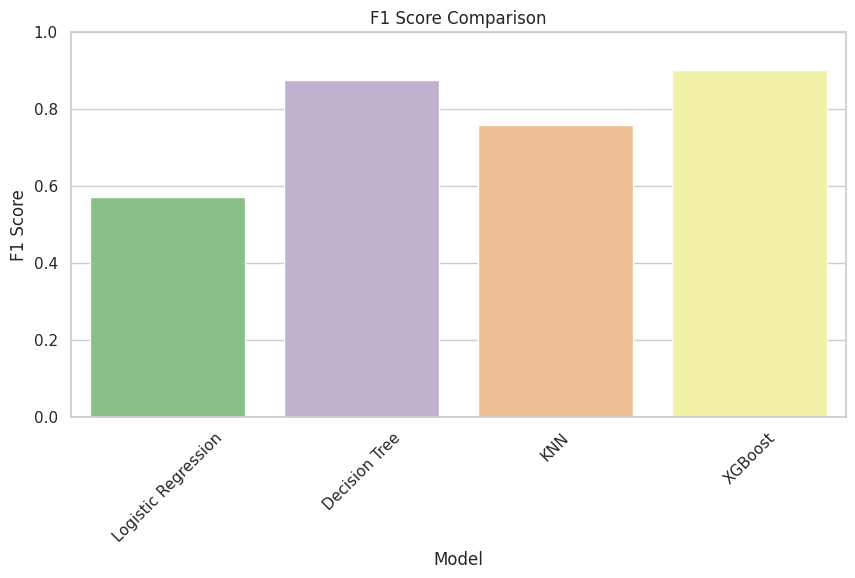

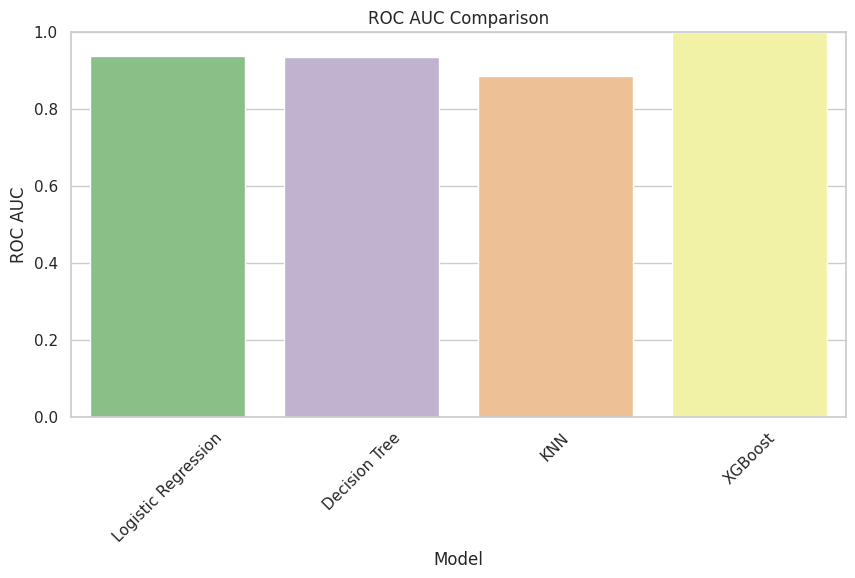

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

zip_path = '/content/onlinefraud.csv.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

csv_path = '/content/onlinefraud.csv'
df = pd.read_csv(csv_path)

plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df, palette='viridis')
plt.title('Fraud vs Non-Fraud Distribution')
plt.xticks([0,1], ['Not Fraud', 'Fraud'])
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='type', data=df, palette='Set2', order=df['type'].value_counts().index)
plt.title('Transaction Type Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['amount'] < 10000], x='isFraud', y='amount', palette='coolwarm')
plt.title('Transaction Amount by Fraud Status (<10k)')
plt.xlabel('Is Fraud?')
plt.ylabel('Transaction Amount')
plt.show()

df['type'] = LabelEncoder().fit_transform(df['type'])
df_corr = df.drop(['nameOrig', 'nameDest'], axis=1)

plt.figure(figsize=(12, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

plt.figure(figsize=(10, 6))
sns.countplot(x='type', hue='isFraud', data=df, palette='mako')
plt.title('Fraud Distribution by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

num_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for feature in num_features:
    plt.figure(figsize=(10, 4))
    sns.kdeplot(data=df[df[feature] < 100000], x=feature, hue='isFraud', fill=True, common_norm=False, palette='Set1')
    plt.title(f'{feature} Distribution by Fraud')
    plt.show()

X = df.drop('isFraud', axis=1)
y = df['isFraud']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []
roc_curves = {}

for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': auc
    })

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves[name] = (fpr, tpr, auc)

plt.figure(figsize=(10,6))
for name, (fpr, tpr, auc_val) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='F1 Score', ascending=False))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=results_df, x='Model', y=metric, palette='Accent')
    plt.title(f'{metric} Comparison')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.show()
